In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [16]:
df_pcs_demographics = pd.read_csv("./pcs_cohort_demographics_rg.csv", index_col=0)
df_tip_demographics = pd.read_csv("./tip_cohort_demographics_rg.csv", index_col=0)
df_human_services = pd.read_csv("./tip_cohort_human_services_activity.csv", index_col=0)
df_uibenefits = pd.read_csv("./tip_cohort_uibenefits.csv", index_col=0)
df_uiearnings = pd.read_csv("./tip_cohort_uiearnings.csv", index_col=0)
df_sentencing_data = pd.read_csv("./TIP_MergedSentencingData.csv", index_col=0)

C:\Users\13429\AppData\Local\Temp\ipykernel_21180\3827111412.py:5: DtypeWarning: Columns (3,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_uiearnings = pd.read_csv("./tip_cohort_uiearnings.csv", index_col=0)


# TIP_MergedSentencingData EDA

In [17]:
df_sentencing_data.head()

,DOB,GraduatedDate,InterviewedDate,StartDate,EndDate,DriversLicense,Course,CreatedDate,DOF,DOS,OGS,INCMIN,PCS_OFF_ID,YearsSinceTIP,offense_indicator
tip_id,,,,,,,,,,,,,,,
1,1992-08-26,NaN,NaN,2018-07-12,2018-08-01,No,Introduction to Masonry,2018-07-11,2016-01-09,2016-07-12,9.0,NaN,1068451.0,-2.505185,1
1,1992-08-26,NaN,NaN,2018-07-12,2018-08-01,No,Introduction to Masonry,2018-07-11,2016-01-09,2016-07-12,3.0,NaN,1068451.0,-2.505185,1
1,1992-08-26,NaN,NaN,2018-07-12,2018-08-01,No,Introduction to Masonry,2018-07-11,2016-01-09,2016-07-12,10.0,NaN,1068451.0,-2.505185,1
2,1997-01-27,NaN,NaN,2018-07-12,NaN,No,Introduction to Masonry,2018-07-11,2017-05-02,2018-05-22,9.0,NaN,1041834.0,-1.193727,1
2,1997-01-27,NaN,NaN,2018-07-12,NaN,No,Introduction to Masonry,2018-07-11,2017-05-02,2018-05-22,1.0,0.131579,1041834.0,-1.193727,1


In [18]:
df = df_sentencing_data.copy()

# -------------------------
# 0) Basic info
# -------------------------
print("=== BASIC INFO ===")
print("Shape:", df.shape)

# tip_id may be in the index or in a column
if df.index.name == "tip_id":
    tip_id_series = df.index.to_series()
elif "tip_id" in df.columns:
    tip_id_series = df["tip_id"]
else:
    tip_id_series = None

print("Columns:", list(df.columns))
print("\nDtypes:")
print(df.dtypes.sort_values())

# -------------------------
# 1) Missingness overview
# -------------------------
print("\n=== MISSINGNESS ===")
missing = df.isna().mean().sort_values(ascending=False)
missing_count = df.isna().sum().sort_values(ascending=False)
missing_tbl = pd.DataFrame({
    "missing_rate": missing,
    "missing_count": missing_count,
})
print(missing_tbl.head(20))

# -------------------------
# 2) Duplicate rows / duplicate tip_id
# -------------------------
print("\n=== DUPLICATES ===")
print("Duplicate rows:", df.duplicated().sum())

if tip_id_series is not None:
    print("Unique tip_id:", tip_id_series.nunique())
    print("Total rows:", len(tip_id_series))
    dup_ids = tip_id_series.value_counts()
    print("tip_id with >1 rows:", (dup_ids > 1).sum())
    print("Top 10 tip_id by row count:")
    print(dup_ids.head(10))

# -------------------------
# 3) Try parsing date columns (summary only; does not modify original columns)
# -------------------------
print("\n=== DATE PARSING CHECK ===")
date_like_cols = [c for c in df.columns if "date" in c.lower() or c.lower() in ["dob", "dof", "dos"]]
print("Date-like columns detected:", date_like_cols)

parsed_date_stats = []
for c in date_like_cols:
    s = df[c]
    # some columns may already be datetime
    if not np.issubdtype(s.dtype, np.datetime64):
        parsed = pd.to_datetime(s, errors="coerce")
    else:
        parsed = s

    parsed_date_stats.append({
        "col": c,
        "non_null_rate": 1 - s.isna().mean(),
        "parsed_success_rate_among_nonnull": (parsed.notna().sum() / max(s.notna().sum(), 1)),
        "min": parsed.min(),
        "max": parsed.max()
    })

if parsed_date_stats:
    parsed_date_stats_df = pd.DataFrame(parsed_date_stats).sort_values("parsed_success_rate_among_nonnull")
    print(parsed_date_stats_df)

# -------------------------
# 4) Numeric summary (no plots)
# -------------------------
print("\n=== NUMERIC SUMMARY ===")
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric cols:", num_cols)

if len(num_cols) > 0:
    desc = df[num_cols].describe().T
    # add missing rate
    desc["missing_rate"] = df[num_cols].isna().mean()
    print(desc.sort_values("missing_rate", ascending=False).head(25))

# -------------------------
# 5) Categorical top values (top 5 per column)
# -------------------------
print("\n=== CATEGORICAL TOP VALUES (top 5) ===")

cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
date_cols_no_top = [
    "DOB", "GraduatedDate", "InterviewedDate", "StartDate", "EndDate",
    "CreatedDate", "dof", "dos", "DOF", "DOS"  # handle different casing
]
cat_cols = [c for c in cat_cols if c not in date_cols_no_top]
print("Categorical cols:", cat_cols)

for c in cat_cols:
    vc = df[c].value_counts(dropna=False).head(5)
    print(f"\n[{c}] top 5:")
    print(vc)

print("\n=== DATE COLUMNS: TOP 5 YEARS ===")

for c in date_cols_no_top:
    if c not in df.columns:
        continue

    s = pd.to_datetime(df[c], errors="coerce")
    years = s.dt.year  # year only

    print(f"\n[{c}] top 5 years (incl NaN):")
    print(years.value_counts(dropna=False).head(5))


# -------------------------
# 6) Key vars: YearsSinceTIP & offense_indicator
# -------------------------
print("\n=== KEY VARS: YearsSinceTIP & offense_indicator ===")

if "YearsSinceTIP" in df.columns:
    ys = pd.to_numeric(df["YearsSinceTIP"], errors="coerce")
    print("YearsSinceTIP (numeric) summary:")
    print(ys.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]))
    print("Share < 0 (pre-TIP):", (ys < 0).mean())
    print("Share between [0, 1):", ((ys >= 0) & (ys < 1)).mean())
    print("Share >= 1:", (ys >= 1).mean())

if "offense_indicator" in df.columns:
    off = df["offense_indicator"]
    # handle 0/1, True/False, strings
    off_num = pd.to_numeric(off, errors="coerce")
    print("\noffense_indicator value counts:")
    print(off.value_counts(dropna=False))

    if off_num.notna().any():
        print("Offense rate (mean of numeric):", off_num.mean())

# YearsSinceTIP x offense_indicator: bin by time
if ("YearsSinceTIP" in df.columns) and ("offense_indicator" in df.columns):
    ys = pd.to_numeric(df["YearsSinceTIP"], errors="coerce")
    off_num = pd.to_numeric(df["offense_indicator"], errors="coerce")
    tmp = pd.DataFrame({"YearsSinceTIP": ys, "offense": off_num}).dropna()

    # bins: adjust as needed
    bins = [-10, -5, -2, -1, 0, 1, 2, 3, 5, 10]
    labels = [f"({bins[i]},{bins[i+1]}]" for i in range(len(bins)-1)]
    tmp["ys_bin"] = pd.cut(tmp["YearsSinceTIP"], bins=bins, labels=labels, include_lowest=True)

    grp = tmp.groupby("ys_bin").agg(
        n=("offense", "size"),
        offense_rate=("offense", "mean"),
        ys_min=("YearsSinceTIP", "min"),
        ys_max=("YearsSinceTIP", "max"),
    )
    print("\nOffense rate by YearsSinceTIP bin:")
    print(grp)

# -------------------------
# 7) Simple consistency check: within the same tip_id, do DOB / StartDate match?
# -------------------------
print("\n=== CONSISTENCY CHECK WITHIN tip_id ===")
if tip_id_series is not None:
    # make tip_id an explicit column for groupby
    df_tmp = df.copy()
    if "tip_id" not in df_tmp.columns:
        df_tmp = df_tmp.reset_index()  # creates tip_id column (if index.name is tip_id)

    check_cols = [c for c in ["DOB", "StartDate", "EndDate", "Course", "DriversLicense"] if c in df_tmp.columns]
    print("Check cols:", check_cols)

    for c in check_cols:
        nunique_within = df_tmp.groupby("tip_id")[c].nunique(dropna=False)
        inconsistent = (nunique_within > 1).sum()
        print(f"{c}: tip_id with >1 distinct values = {inconsistent} (out of {df_tmp['tip_id'].nunique()})")
        if inconsistent > 0:
            print("  examples tip_id:", nunique_within[nunique_within > 1].head(10).index.tolist())


=== BASIC INFO ===
Shape: (6797, 15)
Columns: ['DOB', 'GraduatedDate', 'InterviewedDate', 'StartDate', 'EndDate', 'DriversLicense', 'Course', 'CreatedDate', 'DOF', 'DOS', 'OGS', 'INCMIN', 'PCS_OFF_ID', 'YearsSinceTIP', 'offense_indicator']

Dtypes:
offense_indicator      int64
OGS                  float64
INCMIN               float64
PCS_OFF_ID           float64
YearsSinceTIP        float64
DOB                   object
GraduatedDate         object
InterviewedDate       object
StartDate             object
EndDate               object
DriversLicense        object
Course                object
CreatedDate           object
DOF                   object
DOS                   object
dtype: object

=== MISSINGNESS ===
                   missing_rate  missing_count
INCMIN                 0.770046           5234
GraduatedDate          0.668236           4542
InterviewedDate        0.547595           3722
YearsSinceTIP          0.434751           2955
EndDate                0.328086           2230

C:\Users\13429\AppData\Local\Temp\ipykernel_21180\4241268117.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = tmp.groupby("ys_bin").agg(


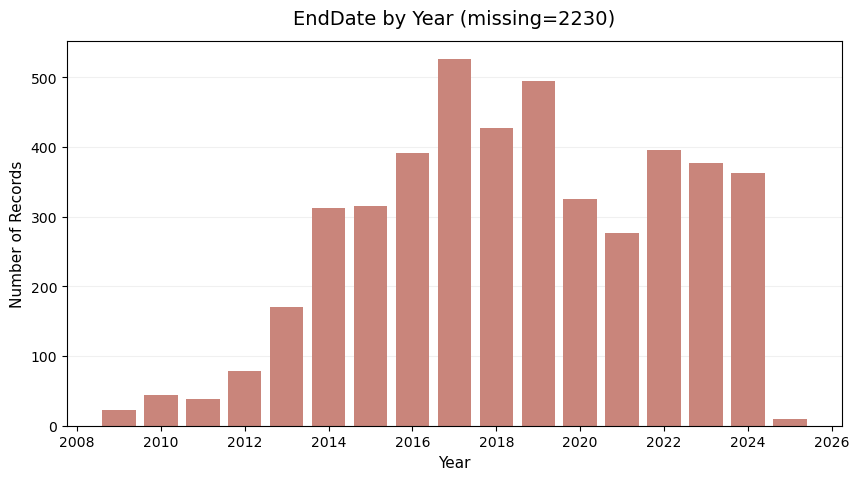

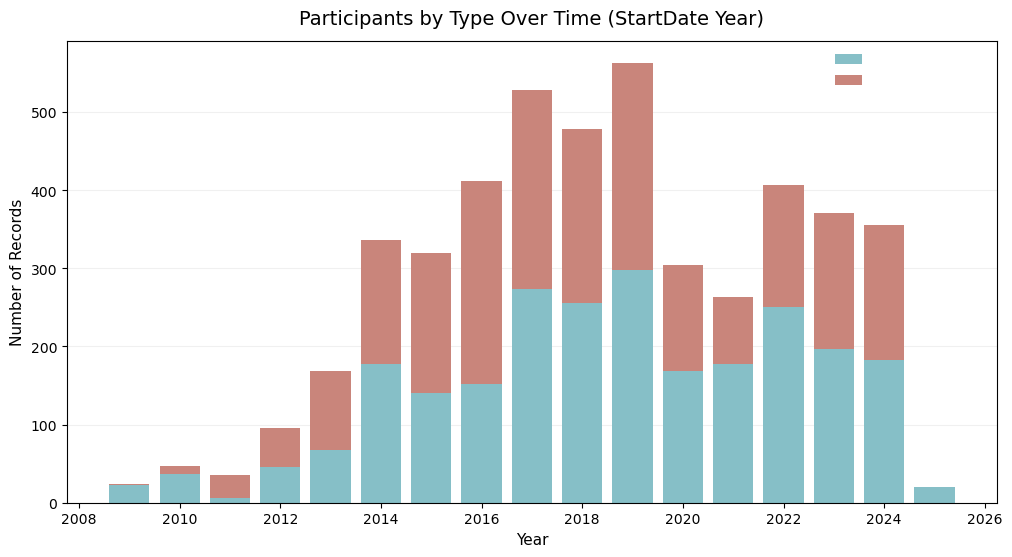

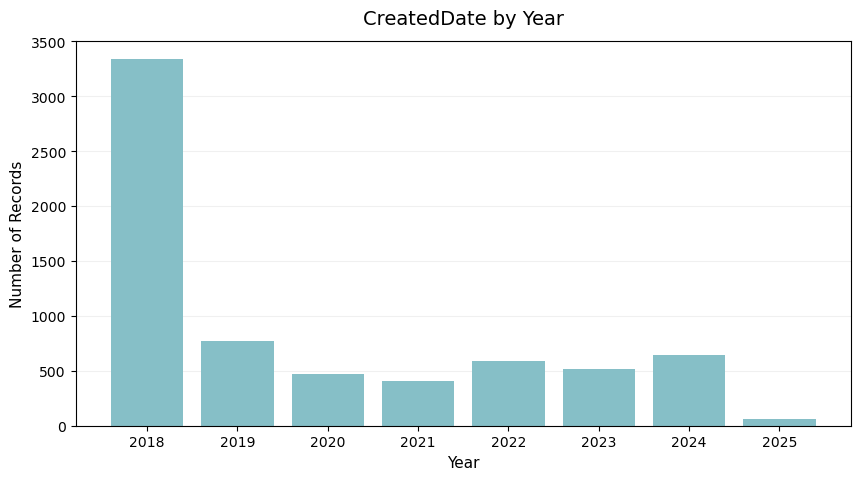

C:\Users\13429\AppData\Local\Temp\ipykernel_21180\771863839.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "graduate_rate": g.apply(lambda x: x["GraduatedDate"].notna().mean() if "GraduatedDate" in x.columns else np.nan)


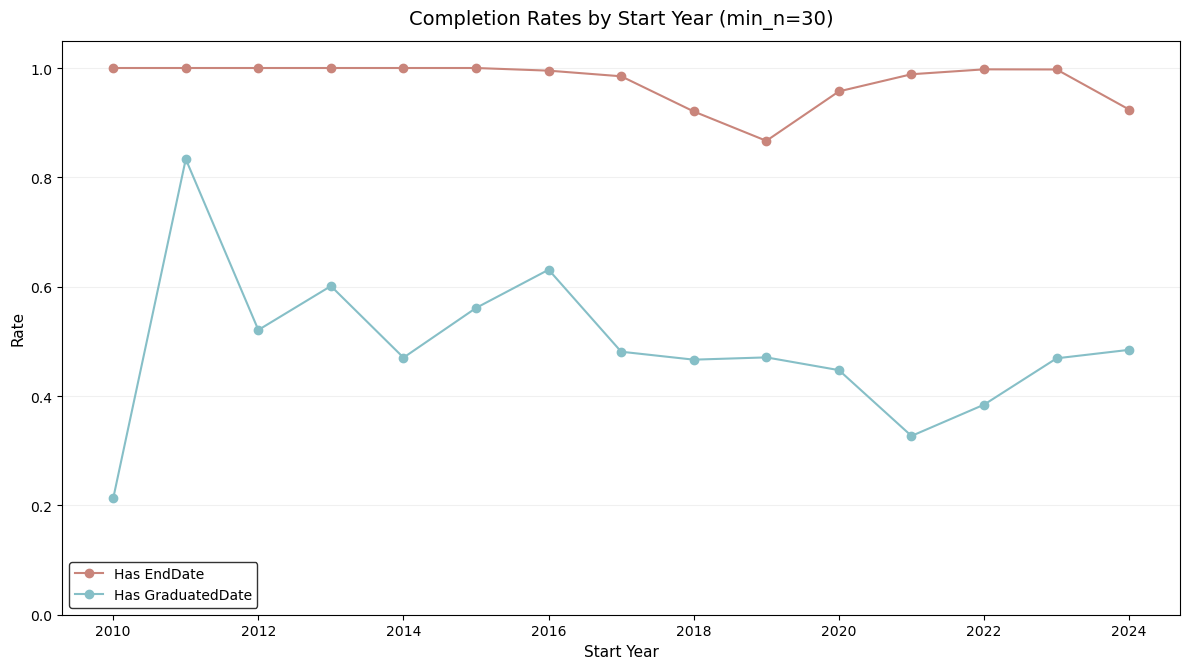

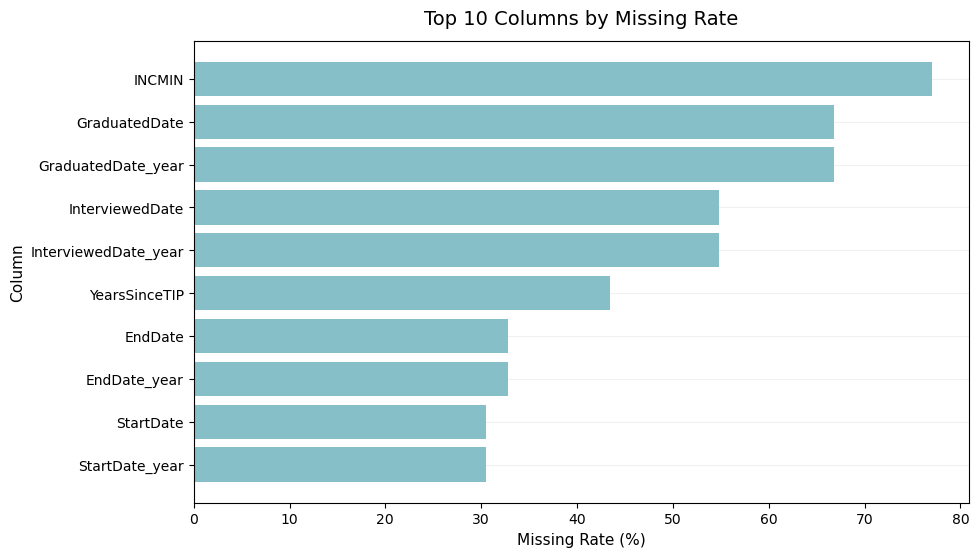

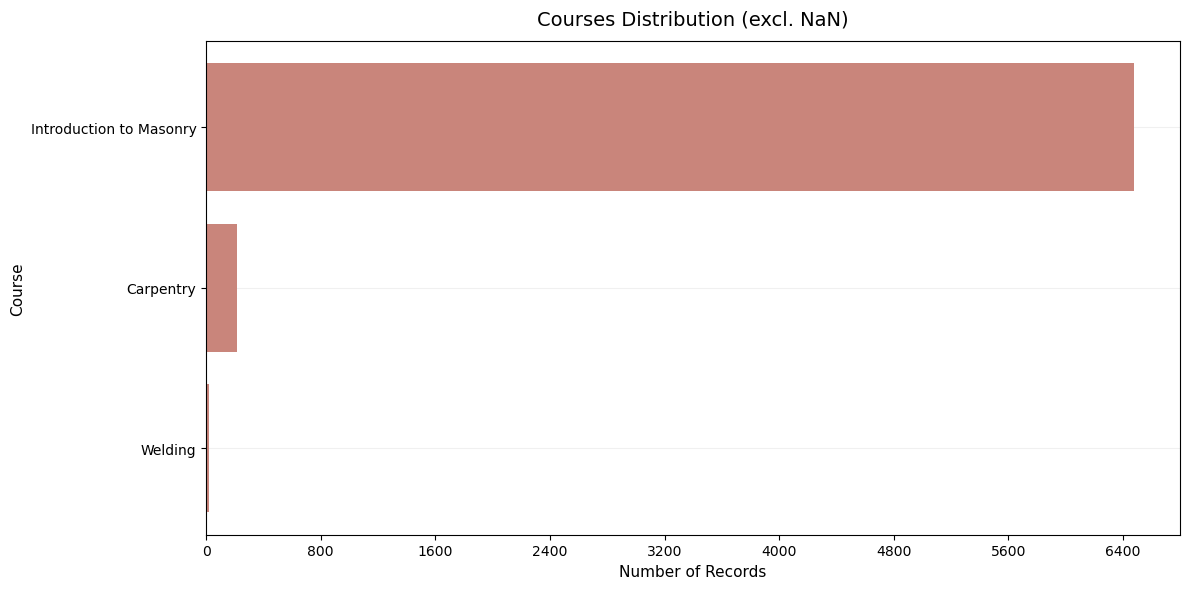

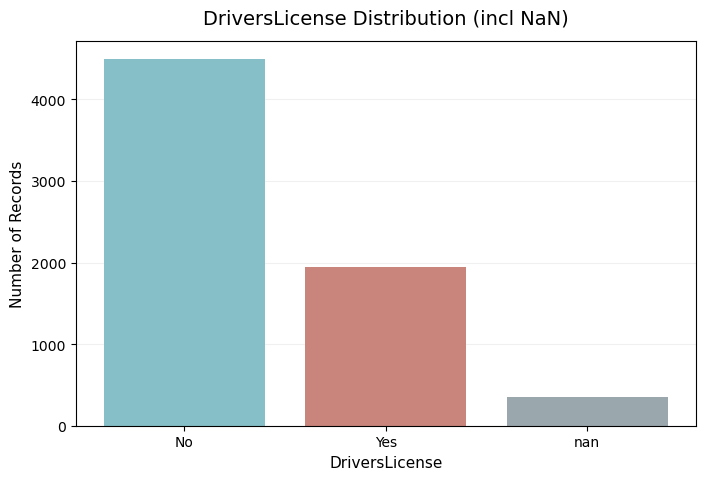

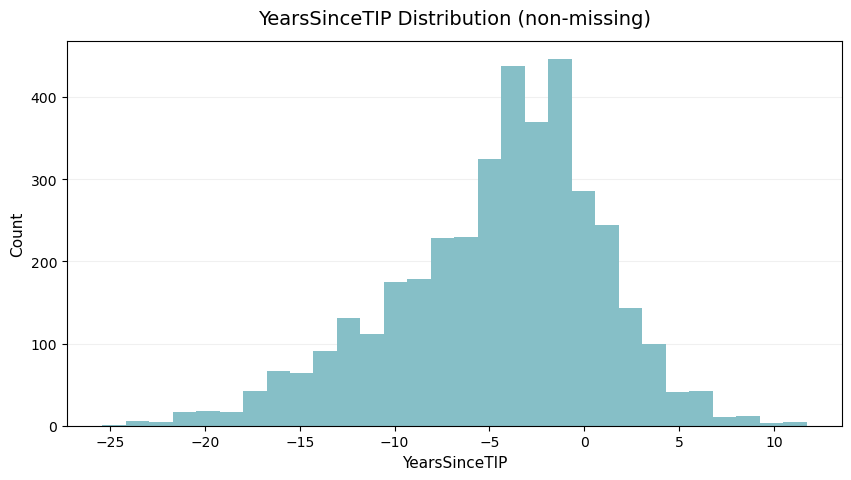

In [19]:
# ---- theme (colors based on your reference screenshot) ----
TEAL   = "#86BFC7"
SALMON = "#C9857B"
GRID   = "#E6E6E6"   # light gray grid (works well on white background)

DATE_COLS = ["DOB","GraduatedDate","InterviewedDate","StartDate","EndDate","CreatedDate","DOF","DOS"]

def to_year(s):
    return pd.to_datetime(s, errors="coerce").dt.year.astype("Int64")

def set_theme(ax, title, xlabel, ylabel):
    ax.set_facecolor("white")
    ax.set_title(title, fontsize=14, pad=12, color="black")
    ax.set_xlabel(xlabel, fontsize=11, color="black")
    ax.set_ylabel(ylabel, fontsize=11, color="black")
    ax.grid(True, axis="y", alpha=0.6, color=GRID)
    ax.set_axisbelow(True)
    ax.tick_params(colors="black")
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    for sp in ax.spines.values():
        sp.set_color("black")

# Participant type: if GraduatedDate exists -> Graduate, otherwise Participant Only
df["_ptype"] = np.where(df.get("GraduatedDate").notna(), "Graduate", "Participant Only")

# Precompute: convert all date columns -> year columns
for c in DATE_COLS:
    if c in df.columns:
        df[c + "_year"] = to_year(df[c])

# =========================
# Plot 1: EndDate by Year (must-have)
# =========================
if "EndDate_year" in df.columns:
    y = df["EndDate_year"]
    missing_n = int(y.isna().sum())
    counts = y.dropna().value_counts().sort_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(counts.index.astype(int), counts.values, color=SALMON, edgecolor="none")
    set_theme(ax, f"EndDate by Year (missing={missing_n})", "Year", "Number of Records")
    plt.show()

# =========================
# Plot 2: StartDate by Year, stacked by Graduate vs Participant Only (similar to your screenshot)
# =========================
if "StartDate_year" in df.columns:
    tmp = df.dropna(subset=["StartDate_year"]).groupby(["StartDate_year", "_ptype"]).size().unstack(fill_value=0).sort_index()

    x = tmp.index.astype(int)
    po = tmp.get("Participant Only", pd.Series(0, index=tmp.index)).values
    gr = tmp.get("Graduate", pd.Series(0, index=tmp.index)).values

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x, po, color=TEAL, label="Participant Only", edgecolor="none")
    ax.bar(x, gr, bottom=po, color=SALMON, label="Graduate", edgecolor="none")
    set_theme(ax, "Participants by Type Over Time (StartDate Year)", "Year", "Number of Records")

    leg = ax.legend(frameon=True)
    leg.get_frame().set_edgecolor("white")
    for t in leg.get_texts():
        t.set_color("white")

    plt.show()

# =========================
# Plot 3: CreatedDate by Year (record creation time distribution)
# =========================
if "CreatedDate_year" in df.columns:
    counts = df["CreatedDate_year"].dropna().value_counts().sort_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(counts.index.astype(int), counts.values, color=TEAL, edgecolor="none")
    set_theme(ax, "CreatedDate by Year", "Year", "Number of Records")
    plt.show()

# =========================
# Plot 4: "Completion rates" by StartDate cohort year (Has EndDate / Has GraduatedDate)
# =========================
# Completion Rates by Start Year (figure taller + headroom)
if "StartDate_year" in df.columns:
    g = df.dropna(subset=["StartDate_year"]).groupby("StartDate_year")
    out = pd.DataFrame({
        "n_records": g.size(),
        "end_rate": g["EndDate_year"].apply(lambda s: s.notna().mean() if "EndDate_year" in df.columns else np.nan),
        "graduate_rate": g.apply(lambda x: x["GraduatedDate"].notna().mean() if "GraduatedDate" in x.columns else np.nan)
    }).sort_index()

    out = out[out["n_records"] >= 30]

    fig, ax = plt.subplots(figsize=(12, 6.8), facecolor="white")  # taller
    ax.plot(out.index.astype(int), out["end_rate"].values, marker="o", color=SALMON, label="Has EndDate")
    ax.plot(out.index.astype(int), out["graduate_rate"].values, marker="o", color=TEAL, label="Has GraduatedDate")
    set_theme(ax, "Completion Rates by Start Year (min_n=30)", "Start Year", "Rate")

    # Add headroom to avoid lines touching the upper boundary
    ax.set_ylim(0, 1.05)          # 0~1 would sit on the border
    ax.margins(y=0.02)

    ax.legend(frameon=True, facecolor="white", edgecolor="black")
    plt.tight_layout()
    plt.show()

# =========================
# Plot 5: Top 10 missing-rate columns (missingness is a key issue here)
# =========================
miss = df.isna().mean().sort_values(ascending=False).head(10) * 100
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(miss.index[::-1], miss.values[::-1], color=TEAL, edgecolor="none")
set_theme(ax, "Top 10 Columns by Missing Rate", "Missing Rate (%)", "Column")
plt.show()

# =========================
# Plot 6: Course distribution (exclude NaN), show ALL categories
# =========================
# Courses distribution (exclude NaN), show ALL categories
if "Course" in df.columns:
    vc = df["Course"].dropna().value_counts()

    fig, ax = plt.subplots(figsize=(12, max(6, 0.35 * len(vc))), facecolor="white")
    ax.barh(vc.index.astype(str)[::-1], vc.values[::-1], color=SALMON, edgecolor="none")
    set_theme(ax, "Courses Distribution (excl. NaN)", "Number of Records", "Course")
    plt.tight_layout()
    plt.show()

# =========================
# Plot 7: DriversLicense distribution
# =========================
if "DriversLicense" in df.columns:
    vc = df["DriversLicense"].value_counts(dropna=False)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(vc.index.astype(str), vc.values, color=[TEAL, SALMON, "#9AA7AD"][:len(vc)], edgecolor="none")
    set_theme(ax, "DriversLicense Distribution (incl NaN)", "DriversLicense", "Number of Records")
    plt.show()

# =========================
# Plot 8: YearsSinceTIP distribution (high missingness, but still informative)
# =========================
if "YearsSinceTIP" in df.columns:
    x = pd.to_numeric(df["YearsSinceTIP"], errors="coerce").dropna()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(x.values, bins=30, color=TEAL, edgecolor="none")
    set_theme(ax, "YearsSinceTIP Distribution (non-missing)", "YearsSinceTIP", "Count")
    plt.show()


# tip_cohort_demographics_rg EDA

In [20]:
df_tip_demographics.head()

,tip_id,year_of_birth,year_of_death,census_tract,gender,race
1,632,1997,NaN,4.200352e+10,Male,Black
2,719,1993,NaN,4.200313e+10,Male,Black
3,302,1994,NaN,4.200356e+10,Male,Black
4,1374,2002,NaN,4.200305e+10,Male,Black
5,2032,2005,NaN,4.200313e+10,Male,Black


In [21]:
print("=== BASIC INFO ===")
print("Shape:", df_tip_demographics.shape)
print("Columns:", list(df_tip_demographics.columns))
print("\nDtypes:")
print(df_tip_demographics.dtypes)

print("\n=== HEAD (5) ===")
print(df_tip_demographics.head())

# -------------------------
# Missingness
# -------------------------
print("\n=== MISSINGNESS ===")
missing_rate = df_tip_demographics.isna().mean().sort_values(ascending=False)
missing_count = df_tip_demographics.isna().sum().sort_values(ascending=False)
missing_tbl = pd.DataFrame({"missing_rate": missing_rate, "missing_count": missing_count})
print(missing_tbl)

# -------------------------
# Duplicates
# -------------------------
print("\n=== DUPLICATES ===")
print("Duplicate rows:", df_tip_demographics.duplicated().sum())

if "tip_id" in df_tip_demographics.columns:
    print("Unique tip_id:", df_tip_demographics["tip_id"].nunique())
    dup_ids = df_tip_demographics["tip_id"].value_counts()
    print("tip_id with >1 rows:", (dup_ids > 1).sum())
    if (dup_ids > 1).any():
        print("Top 10 tip_id by row count:")
        print(dup_ids.head(10))
else:
    print("No tip_id column found.")

# -------------------------
# Numeric summary
# -------------------------
print("\n=== NUMERIC SUMMARY ===")
num_cols = df_tip_demographics.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric cols:", num_cols)

if num_cols:
    desc = df_tip_demographics[num_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
    desc["missing_rate"] = df_tip_demographics[num_cols].isna().mean()
    print(desc.sort_values("missing_rate", ascending=False))

# -------------------------
# Categorical summary (top values)
# -------------------------
print("\n=== CATEGORICAL SUMMARY (top 10 each) ===")
cat_cols = df_tip_demographics.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print("Categorical cols:", cat_cols)

for c in cat_cols:
    print(f"\n[{c}] value counts (top 10, incl NaN):")
    print(df_tip_demographics[c].value_counts(dropna=False).head(10))

# -------------------------
# Year fields sanity checks
# -------------------------
print("\n=== YEAR FIELDS SANITY CHECK ===")
for c in ["year_of_birth", "year_of_death"]:
    if c in df_tip_demographics.columns:
        s = pd.to_numeric(df_tip_demographics[c], errors="coerce")
        print(f"\n{c}:")
        print("  non-missing:", s.notna().sum(), "/", len(s))
        print("  min/max:", s.min(), s.max())

        if "tip_id" in df_tip_demographics.columns:
            bad = df_tip_demographics.loc[s.notna() & ((s < 1900) | (s > 2030)), ["tip_id", c]]
        else:
            bad = df_tip_demographics.loc[s.notna() & ((s < 1900) | (s > 2030)), [c]]

        print("  suspicious years count:", len(bad))
        if len(bad) > 0:
            print(bad.head(10))

# -------------------------
# census_tract checks (scientific notation / decimals / string length)
# -------------------------
if "census_tract" in df_tip_demographics.columns:
    print("\n=== CENSUS_TRACT CHECK ===")
    ct = df_tip_demographics["census_tract"]

    print("dtype:", ct.dtype)
    print("missing:", ct.isna().sum())
    print("nunique (non-missing):", ct.nunique(dropna=True))

    if np.issubdtype(ct.dtype, np.number):
        ct_num = ct.dropna()
        frac_share = (ct_num % 1 != 0).mean() if len(ct_num) else np.nan
        print("share with fractional part (!= integer):", frac_share)

        print("examples (raw):", ct_num.head(5).tolist())

        ct_as_int = ct_num.astype("Int64")
        ct_str = ct_as_int.astype(str)
        print("string length (min/median/max):", ct_str.str.len().min(), ct_str.str.len().median(), ct_str.str.len().max())
        print("examples (as int string):", ct_str.head(5).tolist())
    else:
        ct_str = ct.dropna().astype(str)
        print("string length (min/median/max):", ct_str.str.len().min(), ct_str.str.len().median(), ct_str.str.len().max())
        print("top 10 values:")
        print(ct_str.value_counts().head(10))

# -------------------------
# Cross-field consistency (death before birth)
# -------------------------
print("\n=== QUICK CONSISTENCY CHECKS ===")
if ("year_of_birth" in df_tip_demographics.columns) and ("year_of_death" in df_tip_demographics.columns):
    yob = pd.to_numeric(df_tip_demographics["year_of_birth"], errors="coerce")
    yod = pd.to_numeric(df_tip_demographics["year_of_death"], errors="coerce")

    if "tip_id" in df_tip_demographics.columns:
        inconsistent = df_tip_demographics.loc[yob.notna() & yod.notna() & (yod < yob),
                                               ["tip_id", "year_of_birth", "year_of_death"]]
    else:
        inconsistent = df_tip_demographics.loc[yob.notna() & yod.notna() & (yod < yob),
                                               ["year_of_birth", "year_of_death"]]

    print("year_of_death < year_of_birth count:", len(inconsistent))
    if len(inconsistent) > 0:
        print(inconsistent.head(10))

=== BASIC INFO ===
Shape: (2194, 6)
Columns: ['tip_id', 'year_of_birth', 'year_of_death', 'census_tract', 'gender', 'race']

Dtypes:
tip_id             int64
year_of_birth      int64
year_of_death    float64
census_tract     float64
gender            object
race              object
dtype: object

=== HEAD (5) ===
   tip_id  year_of_birth  year_of_death  census_tract gender   race
1     632           1997            NaN  4.200352e+10   Male  Black
2     719           1993            NaN  4.200313e+10   Male  Black
3     302           1994            NaN  4.200356e+10   Male  Black
4    1374           2002            NaN  4.200305e+10   Male  Black
5    2032           2005            NaN  4.200313e+10   Male  Black

=== MISSINGNESS ===
               missing_rate  missing_count
year_of_death      0.964448           2116
census_tract       0.007748             17
race               0.007748             17
gender             0.001823              4
tip_id             0.000000              

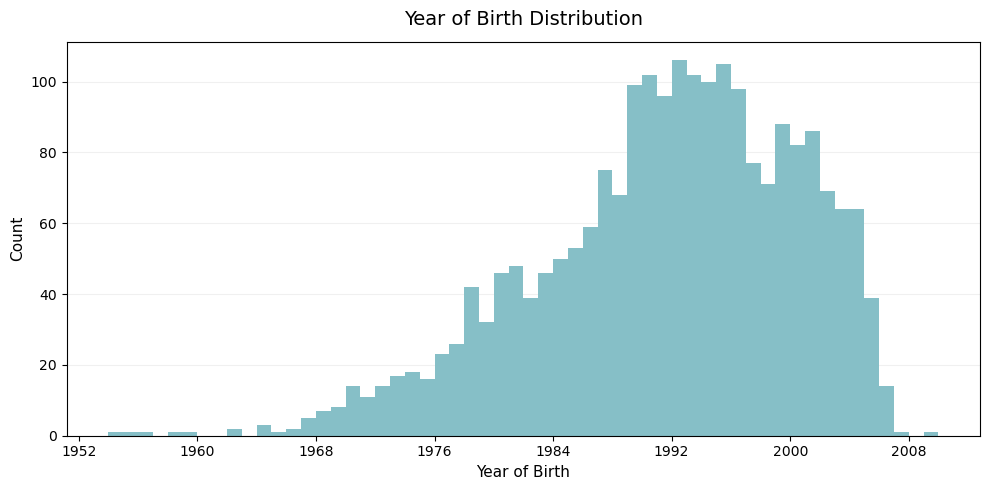

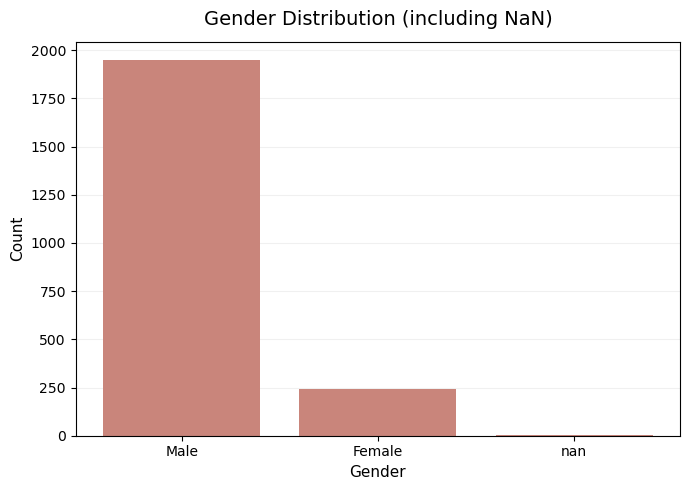

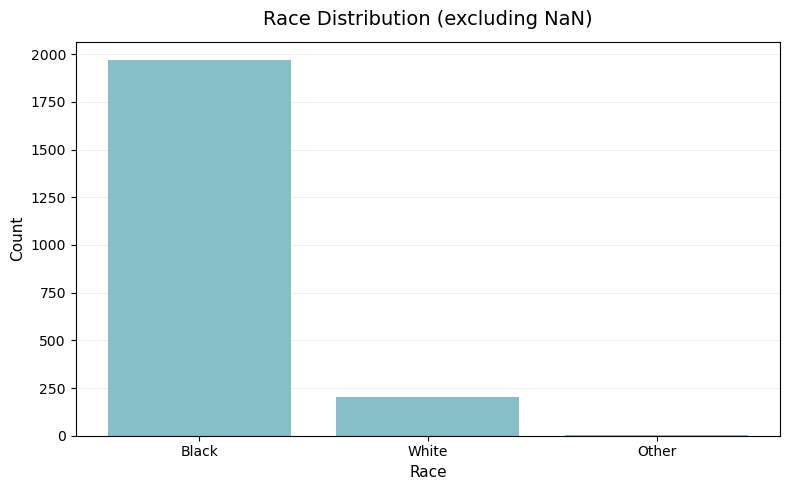

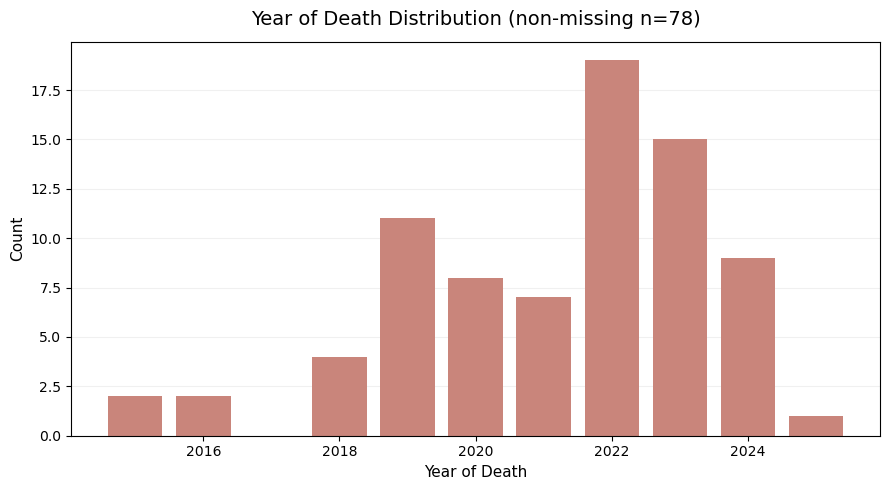

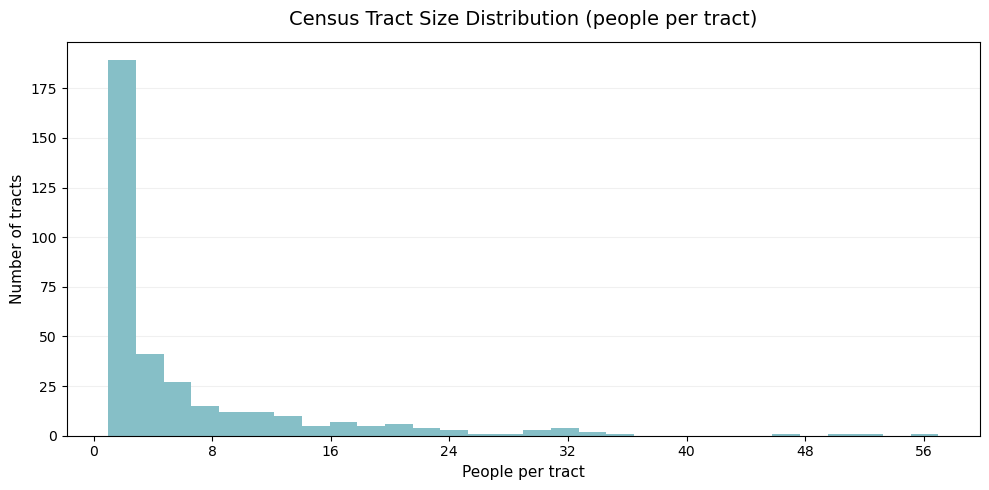

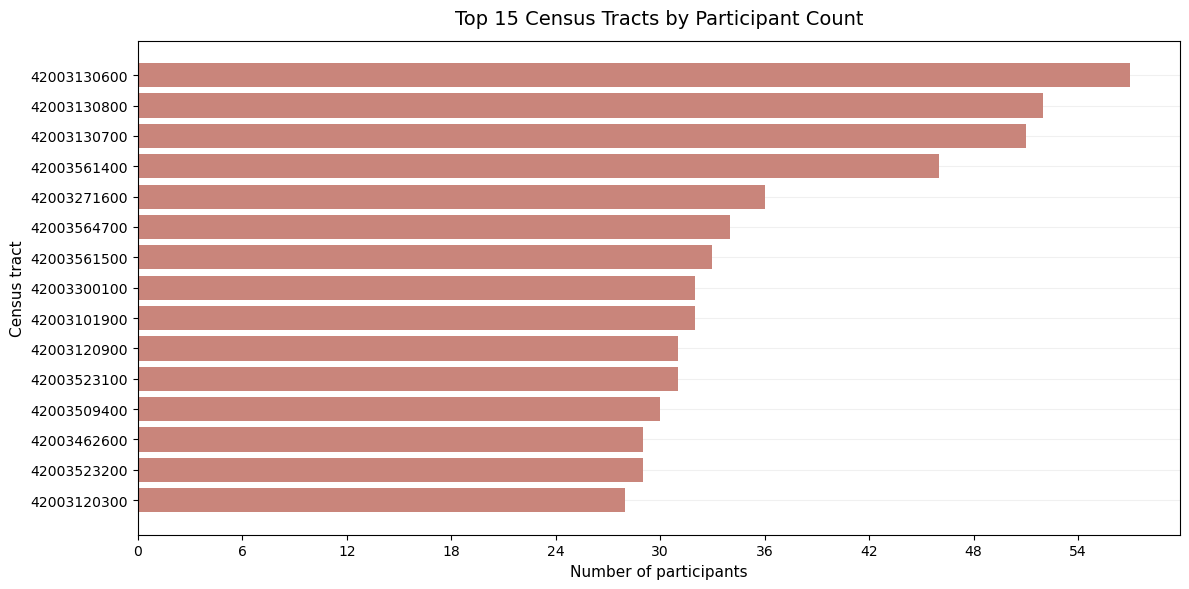

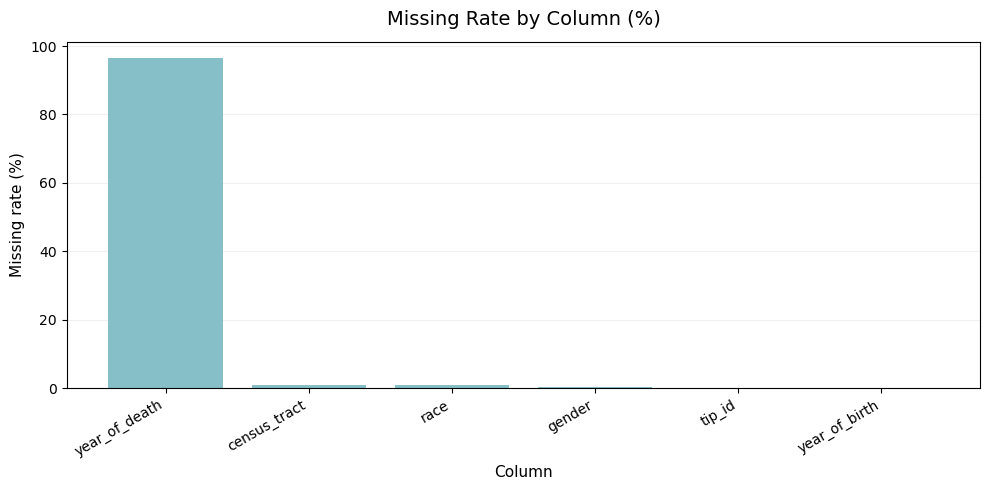

In [22]:
# =========================
# 1) Year of birth distribution
# =========================
yob = df_tip_demographics["year_of_birth"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(yob, bins=range(int(yob.min()), int(yob.max()) + 2), color=TEAL, edgecolor="none")
set_theme(ax, "Year of Birth Distribution", "Year of Birth", "Count")
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

# =========================
# 2) Gender distribution (incl NaN)
# =========================
gender_counts = df_tip_demographics["gender"].value_counts(dropna=False)
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(gender_counts.index.astype(str), gender_counts.values, color=SALMON, edgecolor="none")
set_theme(ax, "Gender Distribution (including NaN)", "Gender", "Count")
plt.tight_layout()
plt.show()

# =========================
# 3) Race distribution (exclude NaN)
# =========================
race_counts = df_tip_demographics["race"].dropna().value_counts()
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(race_counts.index.astype(str), race_counts.values, color=TEAL, edgecolor="none")
set_theme(ax, "Race Distribution (excluding NaN)", "Race", "Count")
plt.tight_layout()
plt.show()

# =========================
# 4) Year of death distribution (non-missing only)
# =========================
yod = df_tip_demographics["year_of_death"].dropna().astype(int)
yod_counts = yod.value_counts().sort_index()
fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(yod_counts.index.astype(int), yod_counts.values, color=SALMON, edgecolor="none")
set_theme(ax, f"Year of Death Distribution (non-missing n={len(yod)})", "Year of Death", "Count")
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

# =========================
# 5) Census tract: people per tract + top tracts
# =========================
# census_tract is float but integer-valued; convert to Int->str to avoid scientific notation
ct = df_tip_demographics["census_tract"].dropna().astype("Int64").astype(str)
ct_counts = ct.value_counts()

# 5a) distribution of tract sizes
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(ct_counts.values, bins=30, color=TEAL, edgecolor="none")
set_theme(ax, "Census Tract Size Distribution (people per tract)", "People per tract", "Number of tracts")
plt.tight_layout()
plt.show()

# 5b) top 15 tracts by count
top_n = 15
top_ct = ct_counts.head(top_n)
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(top_ct.index[::-1], top_ct.values[::-1], color=SALMON, edgecolor="none")
set_theme(ax, f"Top {top_n} Census Tracts by Participant Count", "Number of participants", "Census tract")
plt.tight_layout()
plt.show()

# =========================
# 6) Missingness by column (%)
# =========================
miss_pct = (df_tip_demographics.isna().mean() * 100).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(miss_pct.index, miss_pct.values, color=TEAL, edgecolor="none")
set_theme(ax, "Missing Rate by Column (%)", "Column", "Missing rate (%)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# tip_cohort_uiearnings and tip_cohort_uibenefits merging

In [11]:
df_uiearnings.head()

,tip_id,quarter,employer_legal_name,earnings,naics_code,naics_sector_2017,naics_subsector_2017,naics_industry_2017,naics_sector_2022,naics_subsector_2022,naics_industry_2022
1,655,20182,LEHIGH VALLEY RESTAURANT GROUP INC,1434,722511.0,Accommodation and food services,Food services and drinking places,Full-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,Full-Service Restaurants
2,556,20174,COST COMPANY,3147,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential)
3,556,20174,FRANCO,4654,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential)
4,556,20181,COST COMPANY,1908,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential)
5,556,20181,FRANCO,7165,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential)


In [12]:
df_uibenefits.head()

,TIP_ID,REQUEST_PERIOD,UC_BENEFIT
1,1189,20173,2496.0
2,297,20173,1648.0
3,663,20172,484.0
4,34,20172,1281.0
5,129,20172,2320.0


In [ ]:
earn_keep = [
    "tip_id",
    "quarter",
    "employer_legal_name",
    "earnings",
    "naics_sector_2022",
    "naics_subsector_2022",
    "naics_industry_2022",
]
df_earn_keep = df_uiearnings[earn_keep].copy()

df_earn_keep["tip_id"] = pd.to_numeric(df_earn_keep["tip_id"], errors="coerce").astype("Int64")
df_earn_keep["quarter"] = pd.to_numeric(df_earn_keep["quarter"], errors="coerce").astype("Int64")

# ----------------------------
# 2) benefits
# ----------------------------
df_ben_keep = df_uibenefits[["TIP_ID", "REQUEST_PERIOD", "UC_BENEFIT"]].copy()
df_ben_keep = df_ben_keep.rename(columns={"TIP_ID": "tip_id", "REQUEST_PERIOD": "quarter"})

df_ben_keep["tip_id"] = pd.to_numeric(df_ben_keep["tip_id"], errors="coerce").astype("Int64")
df_ben_keep["quarter"] = pd.to_numeric(df_ben_keep["quarter"], errors="coerce").astype("Int64")
df_ben_keep["UC_BENEFIT"] = pd.to_numeric(df_ben_keep["UC_BENEFIT"], errors="coerce")  # 保持 NA

# ----------------------------
# 3) FULL OUTER JOIN
# ----------------------------
df_ui_merged = df_earn_keep.merge(
    df_ben_keep,
    on=["tip_id", "quarter"],
    how="outer",
)

In [14]:
df_632 = (
    df_ui_merged[df_ui_merged["tip_id"] == 632]
    .sort_values("quarter", na_position="last")
    .reset_index(drop=True)
)

df_632.to_csv("tip_id_632_ui_merged.csv", index=False, encoding="utf-8-sig")